# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
#аугментации изображений
!pip install albumentations -q

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
from datetime import timedelta, datetime, date
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pandas as pd
import re
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# вспомогательные процедуры и функции

# визуализация признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

# преобразование признака Владение в численный
def calc_delta_owned(x):
    if len(x['month']) > 0:
        monthes = float(x['month'][0])
    else:
        monthes = 0.0
        
    if len(x['year']) > 0:
        return float(x['year'][0])*12 + monthes
    elif monthes > 0: 
        return monthes
    else:
        return x['Владение']

In [ ]:
!pip install pandas-profiling
from pandas_profiling import ProfileReport

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.info()

In [ ]:
train.nunique()

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

In [ ]:
#посмотрим, как выглядят распределения числовых признаков

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [91]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'Владение']
# numerical_features = ['mileage', 'productionDate', 'Владение']

In [92]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


## EDA

In [ ]:
ProfileReport(data, title="EDA")


## Результаты EDA:
* в категориальном поле **Владение** большое количество пропусков. Переведем его в числовое значение и , поскольку по этим авто 1 и более владельцев, позже заполним пропуски средним значение.
* поля **productionDate** и **modelDate** сильно коррелированы

Преобразуем поле **Владение** в числовое значение:

In [93]:
df_temp = pd.DataFrame(data['Владение'])
pattern = re.compile('(\d{1} лет)|(\d{1} года)|(\d{1} год)')
df_temp['year'] = df_temp['Владение'].apply(lambda x:str(pattern.findall(str(x))))
pattern = re.compile('(\d{1} месяца)|(\d{1} месяцев)|(\d{1} месяц)|(\d{2} месяцев)')
df_temp['month'] = df_temp['Владение'].apply(lambda x:str(pattern.findall(str(x))))

pattern = re.compile('\d{1}')
df_temp['year'] = df_temp['year'].apply(lambda x:pattern.findall(x))
df_temp['month'] = df_temp['month'].apply(lambda x:pattern.findall(x))
data['Владение'] = df_temp.apply(lambda x: calc_delta_owned(x), axis=1)

In [94]:
    for column in numerical_features:
        data[column].fillna(data[column].median(), inplace=True)

    data['Владение'].fillna(data['Владение'].mean(), inplace=True)

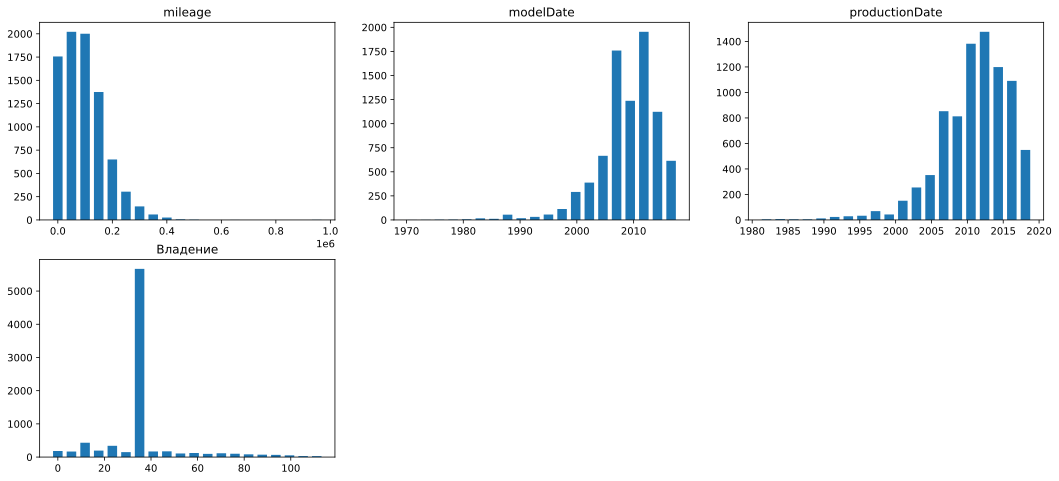

In [77]:
visualize_distributions({
    'mileage': data['mileage'],
    'modelDate': data['modelDate'],
    'productionDate': data['productionDate'],
    'Владение': data['Владение']
})

## прологарифмируем числовые колонки

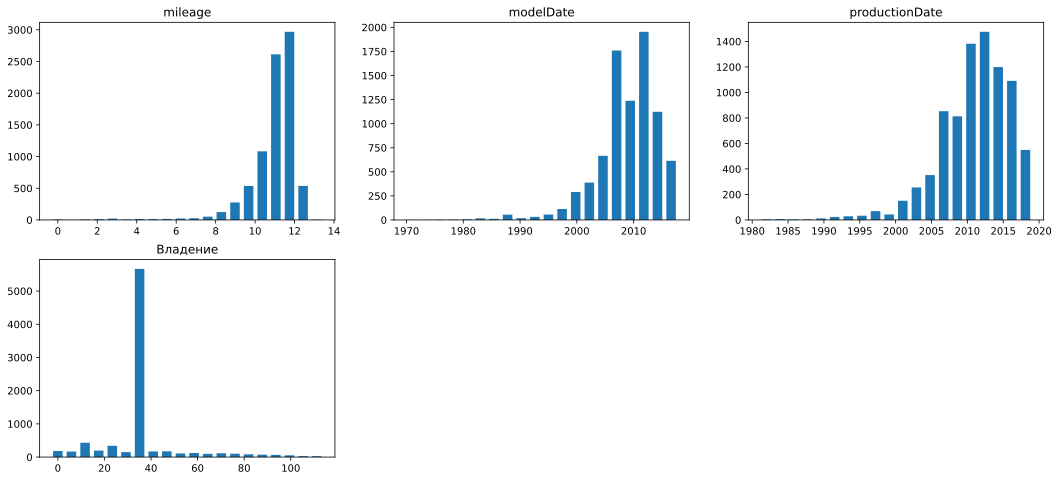

In [95]:
data['mileage'] = data['mileage'].apply(lambda x: np.log(x))
#data['modelDate'] = data['modelDate'].apply(lambda x: np.log(x))
#data['productionDate'] = data['productionDate'].apply(lambda x: np.log(x))
#data['Владение'] = data['Владение'].apply(lambda x: x if x == 0 else np.log(x))
visualize_distributions({
    'mileage': data['mileage'],
    'modelDate': data['modelDate'],
    'productionDate': data['productionDate'],
    'Владение': data['Владение']
})

In [96]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','name'], axis = 1, inplace=True)
    # df_output.drop(['modelDate'], axis = 1, inplace=True) #высокая корреляция с productionDate 
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    df_output['Владение'].fillna(df_output['Владение'].mean(), inplace=True)
    df_output['Владельцы'].fillna(df_output['Владельцы'].value_counts().index[0], inplace=True)
    
    #Уменьшение dummy переменных
    lst_bodyType = list(df_input['bodyType'].value_counts()[:11].index)
    df_output['bodyType'] = df_input['bodyType'].apply(lambda x: x if x in lst_bodyType else 'other')
    
        
    # ################### Feature Engineering ####################################################
    feat_mean = df_output.groupby('bodyType')['price'].mean().to_dict()
    df_output['bodyType_price'] = df_output['bodyType'].map(feat_mean)
    numerical_features.append('bodyType_price') 
    # Средняя цена по бренду, типу кузова и типу топлива оказалась менее эффективной
    '''
    feat_mean = df_output[df_input['sample'] == 1].groupby(['bodyType', 'brand', 'fuelType'])['price'].mean()
    df_output = df_output.merge(feat_mean, how='left', left_on = ['bodyType', 'brand', 'fuelType'], right_on = ['bodyType', 'brand', 'fuelType'])
    df_output.rename(columns = {'price_x': 'price'}, inplace=True)
    df_output['price_y'].fillna(df_output['price_y'].mean(), inplace=True)
    numerical_features.append('price_y') 
    '''
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    label_encoder = LabelEncoder()
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    

    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [97]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)
df_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 384 entries, mileage to Руль_1
dtypes: float64(6), int64(1), uint8(377)
memory usage: 3.4 MB


## Split data

In [98]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
train_data.info()

In [ ]:
test_data.info()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 2: CatBoostRegressor

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

## Simple Dense NN

In [100]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [101]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

## learning rate tuning
заимствовано [отсюда](https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2)

In [ ]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 1.0015 # Reducing lr increased mape 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [102]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
# callbacks_list = [checkpoint, earlystop, LearningRateReducerCb()] # оптимизированть lr не удалось
callbacks_list = [checkpoint, earlystop] 

### Fit

In [103]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

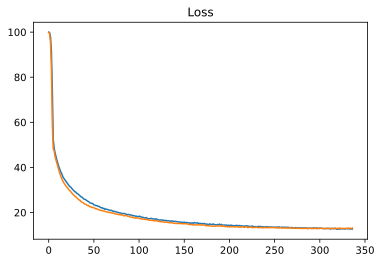

In [104]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [105]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [106]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 13.14%


In [107]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [ ]:
data.description

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Класс для стемминга слов на русском языке заимствован [отсюда](https://github.com/Ventsislav-Yordanov/Blog-Examples/blob/master/Intro%20to%20NLP%20-%20Cleaning%20Review%20Texts%20Example/Cleaning%20Review%20Texts%20Example.ipynb)

In [ ]:

class Porter:
	PERFECTIVEGROUND =  re.compile(u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
	REFLEXIVE = re.compile(u"(с[яь])$")
	ADJECTIVE = re.compile(u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
	PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")
	VERB = re.compile(u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
	NOUN = re.compile(u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
	RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
	DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
	DER = re.compile(u"ость?$")
	SUPERLATIVE = re.compile(u"(ейше|ейш)$")
	I = re.compile(u"и$")
	P = re.compile(u"ь$")
	NN = re.compile(u"нн$")

	def stem(word):
		word = word.lower()
		word = word.replace(u'ё', u'е')
		m = re.match(Porter.RVRE, word)
		if m and m.groups():
			pre = m.group(1)
			rv = m.group(2)
			temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
			if temp == rv:
				rv = Porter.REFLEXIVE.sub('', rv, 1)
				temp = Porter.ADJECTIVE.sub('', rv, 1)
				if temp != rv:
					rv = temp
					rv = Porter.PARTICIPLE.sub('', rv, 1)
				else:
					temp = Porter.VERB.sub('', rv, 1)
					if temp == rv:
						rv = Porter.NOUN.sub('', rv, 1)
					else:
						rv = temp
			else:
				rv = temp
			
			rv = Porter.I.sub('', rv, 1)

			if re.match(Porter.DERIVATIONAL, rv):
				rv = Porter.DER.sub('', rv, 1)

			temp = Porter.P.sub('', rv, 1)
			if temp == rv:
				rv = Porter.SUPERLATIVE.sub('', rv, 1)
				rv = Porter.NN.sub(u'н', rv, 1)
			else:
				rv = temp
			word = pre+rv
		return word
	stem=staticmethod(stem)

Доработаем немного [код для предобработки предложений](https://github.com/Ventsislav-Yordanov/Blog-Examples/blob/master/Intro%20to%20NLP%20-%20Cleaning%20Review%20Texts%20Example/Cleaning%20Review%20Texts%20Example.ipynb) для текста на русском языке с включение английских слов

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_review(review):
    """
    Receives a raw review and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming

    Args:
        review: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    
    review = re.sub("[^А-яа-яA-Za-z]", " ", review)
    review = review.lower()
    review = word_tokenize(review)
   
    review = [Porter.stem(word) for word in review if word not in set(stopwords.words("russian"))]
    review = " ".join(review)
    return review

In [ ]:
#description stemming
data.description = data.description.apply(lambda x: clean_review(x))
data.description[0]

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
tokenize.word_index

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

## Fine tunning

In [ ]:
efficientnet_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(efficientnet_model.layers)/2)

# Freeze all the layers before the `fine_tune_at` layer
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_nn1 + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_nn1[:,0] + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_bonus = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = sub_predict_bonus
sample_submission.to_csv('bonus_submission.csv', index=False)

In [ ]:
# 